In [2]:
import numpy as np
from Env import _5G
import tensorflow as tf
import keras as kr
from keras.optimizers import Adam
from collections import deque
from keras.callbacks import TensorBoard
import random

In [ ]:
REPLAY_MEMORY_SIZE = 10000
MINIBATCH_SIZE = 64
START_TRAIN_replay_memory = 1000
DISCOUNT = 0.99
UPDATE_TARGET_EVERY = 5
MODEL_NAME = '_5G'

In [ ]:
# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)

C:\Users\derec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


AttributeError: '_5G' object has no attribute 'alloc'

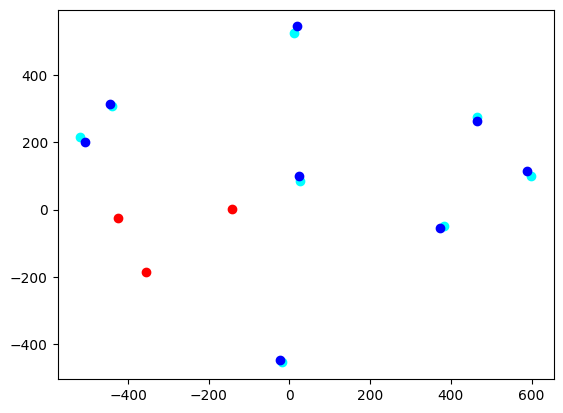

In [3]:
env = _5G(8,3)
state = env.reset()
env.render()

In [99]:
np.array([np.argmax(i) for i in np.random.uniform(size=(8,3))])

array([1, 1, 0, 2, 1, 0, 0, 1], dtype=int64)

# checking if many states' total mean is too noisy

In [4]:
means= []
for _ in range(100):
    state = env.reset()
    tot_m= []
    for __ in range(1000):
        alloc= np.array([np.argmax(i) for i in np.random.uniform(size=(8,3))])
        done, tot, std= env.step(alloc)
        if tot:
            tot_m.append(tot)
    if tot_m:
        means.append(np.mean(tot_m))

print(np.array(means).std())
print(np.array(means).mean())

1.9222688934876169
25.210932419383713


# random sampled distribution

valid: 3793
min: 14.743733574958458
max: 33.64121992209692


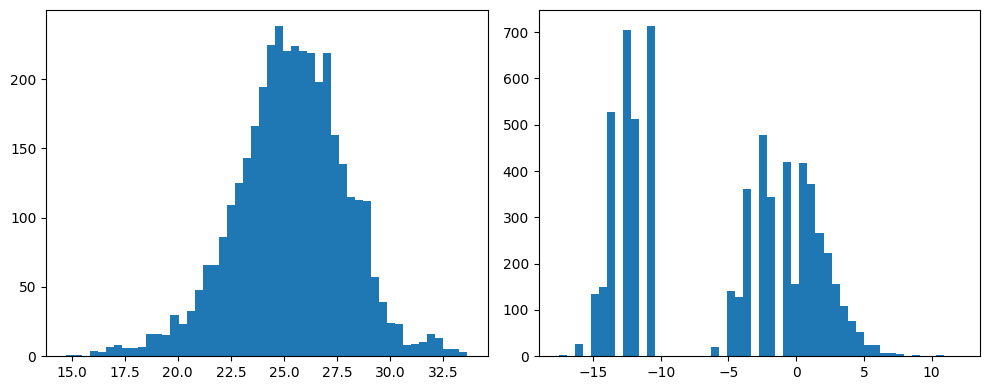

3793
6561


In [113]:
from itertools import product
import  matplotlib.pyplot as plt
count= 0
total_memory= []
total_reward = []
all = list(product([0,1,2], repeat=8))
np.random.shuffle(all)
# tot_mean= [0,0]
#change state changes every 100 actions
CHANGE_STATE_EVERY = 100

for i, alloc in enumerate(all):
    if i % CHANGE_STATE_EVERY == 0:
        env.reset()
    done, tot, std= env.step(np.array(alloc))
    # tot_mean[0] = tot
    reward= 0

    if tot:
        count+=1
        total_memory.append(tot)
        dr = total_memory[-1] - total_memory[-2] if len(total_memory) > 1 else 0
        reward = dr if dr >= 0 else -std * 2
        total_reward.append(reward)

    else:
        reward = -10 - std * 2
        total_reward.append(reward)
# from itertools import product

# count= 0
# total_memory= []

# for alloc in list(product([0,1,2], repeat=8)):
#     done, tot, std= env.step(np.array(alloc))
#     if tot:
#         count+=1
#         total_memory.append(tot)
# print(f'valid: {count}')
print(f'min: {min(total_memory)}')
print(f'max: {max(total_memory)}')
print(f'validity: {len(total_memory)/len(total_reward)}')
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(np.array(total_memory), bins=50)
axs[1].hist(np.array(total_reward), bins=50)
plt.tight_layout()
plt.show()

In [10]:
class DQN_Agent():
    def __init__(self):
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
    
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))
        self.target_update_counter = 0

    def create_model():
        model= kr.Sequential()
        model.add(kr.layers.Flatten(input_shape=(19,)))
        model.add(kr.layers.Dense(32, activation='relu'))
        model.add(kr.layers.Dense(32, activation='relu'))
        model.add(kr.layers.Dense(32, activation='relu'))
        model.add(kr.layers.Dense(8,), activation='sigmoid')
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
        return model
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    def get_qs(self, state):
        return self.model.predict(state.reshape(-1, *state.shape))
    
    def train(self): #GIVE CONDITION FOR TOTAL INVALID STATE
        if len(self.replay_memory) < START_TRAIN_replay_memory:
            return
        
        ######
        #   state-(19)  state_t-(64,19)
        #   q-(8,3)     qs_t-(64,8,3)
        #   alloc-(8)   
        ######

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        states_t = np.array([transition[0] for transition in minibatch])
        qs_t = self.model.predict(states_t)
        # states_t_ = np.array([transition[3] for transition in minibatch])
        qs_t_ = self.target_model.predict(states_t)
        Y=[]
        for index, (state, alloc,  total) in enumerate(minibatch):
            #calculate reward here!!!
            
            y = reward + DISCOUNT * np.array([np.max(i) for i in qs_t_[index]])
            q= qs_t[index]
            for i,j in enumerate(alloc):
                q[i,j] = y[i,j]
            Y.append(q)
        self.model.fit(states_t, np.array(Y), 
                       batch_size=MINIBATCH_SIZE, 
                       verbose=0,
                       shuffle=False,
                       callbacks=[self.tensorboard])
        self.target_update_counter += 1
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0